# State Population and PL contrast

The evolution of the state of a NV- center is computed under optical pumping. 


In [1]:
%load_ext autoreload
%autoreload 2

In [489]:
import itertools

In [2]:
import qutip

In [3]:
import nvmodels
import numpy as np
import scipy.constants

In [4]:
import matplotlib.pyplot as plt

In [7]:
nvmodels.__version__

'0.0.1.dev1'

# Build Hamiltonian

For this demonstration, the hyperfine splitting of nuclear states are excluded.
Subsequent demonstrations should include this. 

We can create NV Hamiltonian factory objects for the electronic ground and excited states, excluding the nuclear states.

In [458]:
nvgs = nvmodels.NVNegativeGroundState(include_nuclear_states = False)

In [459]:
nves = nvmodels.NVNegativeExcitedState(include_nuclear_states = False)

In [508]:
# in order to separtate the -1 and +1 states, we place a static field

B_mag = 25e-4  # 50 Gauss in the z direction


In [519]:
polar = 0
azimuthal = 0
_x = np.sin(polar)*np.cos(azimuthal)
_y = np.sin(polar)*np.sin(azimuthal)
_z = np.cos(polar)
static_B_field = B_mag*np.array([_x, _y, _z])

h_gs = nvgs.zero_field_hamiltonian()
h_gs += nvgs.nitrogen_hyperfine_hamiltonian() #with include nuclear states = False, this line actually does nothing. But we keep it here for future demonstrations
h_gs += nvgs.nitrogen_electric_quadrupole_hamiltonian()  #with include nuclear states = False, this line actually does nothing. But we keep it here for future demonstrations
h_gs += nvgs.static_mag_field_hamiltonian(static_B_field)


#NB - the excited electronic state hamiltonian does NOT include the ~470 THz energy difference
# above the ground state. However, as can be seen a few lines below, 
# about 4 GHz is addes to the hamiltonian in order to raise
# the exctied states above the ground state. This will assist in visualizing the states later

h_es = nves.zero_field_hamiltonian()
h_es += nves.nitrogen_hyperfine_hamiltonian()  #with include nuclear states = False, this line actually does nothing. But we keep it here for future demonstrations
h_es += nves.nitrogen_electric_quadrupole_hamiltonian()  #with include nuclear states = False, this line actually does nothing. But we keep it here for future demonstrations
h_es += nves.static_mag_field_hamiltonian(static_B_field)

h_es += 6e9*qutip.qeye(3) #add E to the excited state so we can properly separate

### Combine into single Hamiltonian

We now combine the ground, excited and an inter-system crossing state into a single Hamiltonian

```
|  H_gs        | 
|       H_es   |
|            S |
```


In [523]:

#combine into single hamiltonian
ISC_size = 1 + 2*nvgs.include_nuclear_states  #note, we are neglecting 1E ISC state which has a lifetime of 1 ns. the 1A1 lifetime is 300 ns. 
  
full_h_shape = h_gs.shape[0] + h_es.shape[0] + ISC_size

hh = np.zeros((full_h_shape,full_h_shape), dtype=np.cdouble)

gs_idx = [0, h_gs.shape[0] , 0, h_gs.shape[1]]
hh[gs_idx[0]:gs_idx[1], gs_idx[2]:gs_idx[3]] = h_gs

es_idx = [gs_idx[1], gs_idx[1] + h_es.shape[0] , gs_idx[3], gs_idx[3] + h_es.shape[1]]
hh[es_idx[0]:es_idx[1], es_idx[2]:es_idx[3]] = h_es

ss_idx = [es_idx[1], es_idx[1] + ISC_size , es_idx[3], es_idx[3] + ISC_size]
hh[ss_idx[0]:ss_idx[1], ss_idx[2]:ss_idx[3]]  = np.eye(ISC_size)*2.5e9 # we artificially raise the E of the ISC so that we can visualize the states later

hh_full = qutip.Qobj(hh)

#### Examine the H_gs (electronic ground state)

Remember, only shown are the electronic states (no nuclear hyperfine interaction)


Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 1.02674587e+09  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.91333333e+09  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  8.86587468e+08]]


Text(0.5, 0, 'State index')

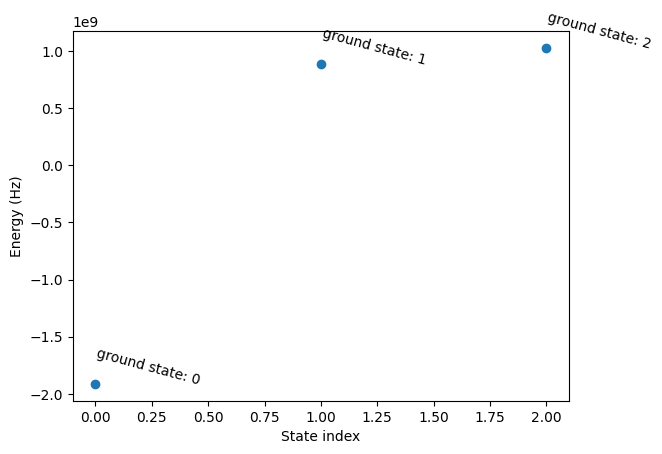

In [524]:
print(h_gs)
eigenvalues, eigenstates = h_gs.eigenstates()
state_probs_text = [f'ground state: {i}' for i,s in enumerate(eigenstates)]

fig, ax = nvmodels.plotting.plot_eigenspectrum_mpl(eigenvalues, state_probs_text)
ax.set_ylabel('Energy (Hz)')
ax.set_xlabel('State index')

#### Examine the H_es (electronic excited state)

Remember, only shown are the electronic states (no nuclear hyperfine interaction)

It should be noted that the excited state Hamiltonian does not include the ~470 THz energy difference
relative to the ground state. This is not necessary for our computation. 

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[6.71674587e+09 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.70666667e+09 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 6.57658747e+09]]


Text(0.5, 0, 'State index')

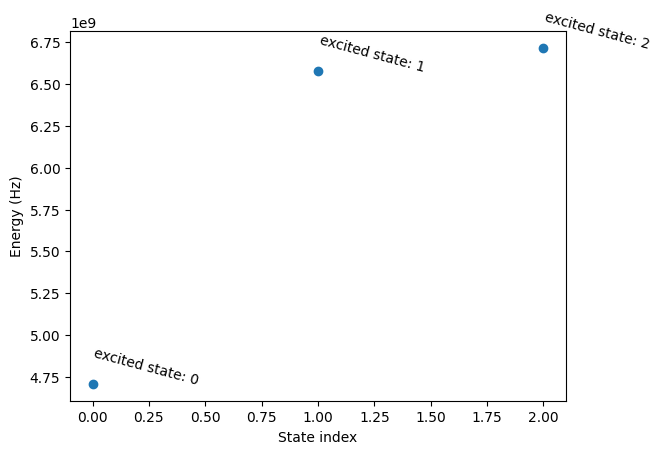

In [525]:
print(h_es)
eigenvalues, eigenstates = h_es.eigenstates()
state_probs_text = [f'excited state: {i}' for i,s in enumerate(eigenstates)]

fig, ax = nvmodels.plotting.plot_eigenspectrum_mpl(eigenvalues, state_probs_text)
ax.set_ylabel('Energy (Hz)')
ax.set_xlabel('State index')

#### Examine the H_full

This is the full Hamiltonian, including the long-lived inter-system crossing state.

It should be noted that the excited state Hamiltonian does not include the ~470 THz energy difference
relative to the ground state. As such, the excited states will appear in the plot at similar energy scale as
the ground state

Quantum object: dims = [[7], [7]], shape = (7, 7), type = oper, isherm = True
Qobj data =
[[ 1.02674587e+09  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.91333333e+09  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  8.86587468e+08  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  6.71674587e+09
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   4.70666667e+09  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  6.57658747e+09  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  2.50000000e+09]]


Text(0.5, 0, 'State index')

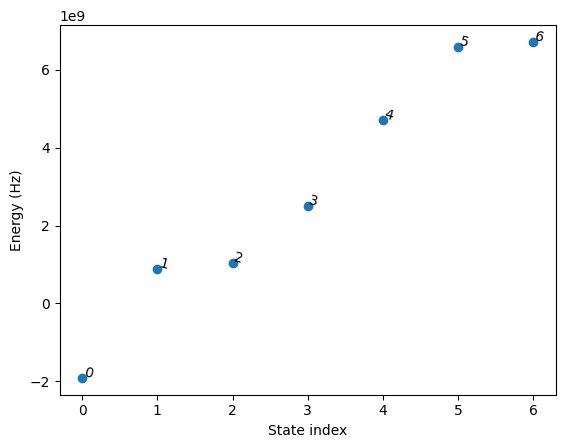

In [526]:
print(hh_full)
eigenvalues, eigenstates = hh_full.eigenstates()
state_probs_text = [f'{i}' for i,s in enumerate(eigenstates)]

fig, ax = nvmodels.plotting.plot_eigenspectrum_mpl(eigenvalues, state_probs_text)
ax.set_ylabel('Energy (Hz)')
ax.set_xlabel('State index')

# State Identificaion


* 0  -->  3A2, ground state, ms = 0
* 1-2 --> 3A2, ground state, ms = +-1

* 3 --> A1, ISC crossing state


* 4  -->  3E, excited state, ms = 0
* 5-6 --> 3E, excited state, ms = +-1


Energy level diagram with state index


```
ms = 0        
                 ---- 6 (ms = +1)
                 ---- 5 (ms = -1)
---- 4
          ISC
        ---- 3
                ----- 2 (ms = +1)
                ----- 1 (ms = -1)
---- 0
```


In [800]:
dict(gs_0 = 0,
gs_m1 = 1 ,
gs_p1 = 2,
isc = 3  ,
es_0 = 4 ,
es_m1 = 5,
es_p1 = 6)

{'gs_0': 0,
 'gs_m1': 1,
 'gs_p1': 2,
 'isc': 3,
 'es_0': 4,
 'es_m1': 5,
 'es_p1': 6}

In [528]:
gs_0 = 0 # ground state, ms = 0
gs_m1 = 1 # ground state, ms = -1
gs_p1 = 2 # ground state, ms = +1
isc = 3  
es_0 = 4  # excited state ms = 0
es_m1 = 5 # excited state ms = -1
es_p1 = 6 # excited state ms = +1

# Build Lindblad Collapse Operators

The Lindblad operators in the master equations describe the transtions between states; includes optical pumping, spontaneous emission, intersystem crossing rates and relaxation

## Define Transition Rates

Create a matrix of transition rates between states.

https://journals.aps.org/prapplied/pdf/10.1103/PhysRevApplied.19.034061

In [756]:
gamma = np.zeros(hh_full.shape)
#gamma[l, m] = transition rate from state l to state m

### Optical Pumping

We add transition from the ground to the excited electronic states

In [798]:
gamma.shape

(7, 7)

In [757]:

watts = 3
optical_pumping_rate = 1.1e6 * watts # optical pumping rate (example: 1/285e-9 = 3.5 MHz

gamma[gs_0,es_0] = optical_pumping_rate
gamma[gs_m1,es_m1] = optical_pumping_rate
gamma[gs_p1,es_p1] = optical_pumping_rate

#### Spontaneous Emission

In [758]:
spontaneous_emission = 1/15.8e-9  

gamma[es_0,gs_0] = spontaneous_emission
gamma[es_m1,gs_m1] = gamma[es_p1,gs_p1] = 1/15.9e-9

#### Relaxation

In [759]:
#boltzmann relaxation

# decay from g, ms=+-1 -> g ms=0
gamma[gs_m1,gs_0] = 1./3e-3 # milliseconds 
gamma[gs_p1,gs_0] = gamma[gs_m1,gs_0]

# rate the other way is relatively affected by energy difference
room_temp = scipy.constants.physical_constants['Boltzmann constant in Hz/K'][0] * nvgs.temperature
gamma[gs_0,gs_m1] = gamma[gs_m1,gs_0]*np.exp(-nvgs.zero_field_splitting()/room_temp)
gamma[gs_0,gs_p1] = gamma[gs_p1,gs_0]*np.exp(-nvgs.zero_field_splitting()/room_temp)

#### Inter System Crossing

This is responsible for the ability to pump from the ms = +-1 states to the ms = 0 state

In [760]:
#ISC crossing from 3E to A1
gamma[es_m1,isc] = gamma[es_p1,isc] = 1/12.5e-9
gamma[es_0,isc] = 1/76.9e-9 

#ISC from A1 to 3A2
gamma[isc,gs_0] = 1/289e-9   
gamma[isc,gs_m1] = gamma[isc,gs_p1] = 1/463e-9  

### Build the Lindblad Operators

In [761]:
# projection operator |m >< l|
def projection(s, from_l, to_m):
    return qutip.basis(s,to_m)*qutip.basis(s,from_l).dag()

In [762]:
# create dictionary of lindblad operators based on non-zero values of gamma
L = {f'{l}->{m}':np.sqrt(gamma[l,m])*projection(full_h_shape, l, m) 
         for l,m in itertools.product(range(full_h_shape), range(full_h_shape)) if gamma[l,m]!=0}

In [763]:
print(gamma[gs_0,es_0])
L[f'{gs_0}->{es_0}']

3300000.0


Quantum object: dims = [[7], [7]], shape = (7, 7), type = oper, isherm = False
Qobj data =
[[   0.            0.            0.            0.            0.
     0.            0.        ]
 [   0.            0.            0.            0.            0.
     0.            0.        ]
 [   0.            0.            0.            0.            0.
     0.            0.        ]
 [   0.            0.            0.            0.            0.
     0.            0.        ]
 [1816.59021246    0.            0.            0.            0.
     0.            0.        ]
 [   0.            0.            0.            0.            0.
     0.            0.        ]
 [   0.            0.            0.            0.            0.
     0.            0.        ]]

# Define Observables

In [764]:
#number of photons associated with spontaneous emission, 
#which is proportional to the population of the excited states 

In [765]:
PL_rate = gamma[es_0,gs_0]*projection(full_h_shape, es_0, es_0)/gamma[es_0,:].sum()
PL_rate += gamma[es_m1,gs_m1]*projection(full_h_shape, es_m1, es_m1)/gamma[es_m1,:].sum()
PL_rate += gamma[es_p1,gs_p1]*projection(full_h_shape, es_p1, es_p1)/gamma[es_p1,:].sum()

In [766]:
PL_rate

Quantum object: dims = [[7], [7]], shape = (7, 7), type = oper, isherm = True
Qobj data =
[[0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.82955771 0.
  0.        ]
 [0.         0.         0.         0.         0.         0.44014085
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.44014085]]

In [770]:
#population of excited state 

P_es = projection(full_h_shape, es_0, es_0)
P_es += projection(full_h_shape, es_m1, es_m1) 
P_es += projection(full_h_shape, es_p1, es_p1)

#population of ground state
P_gs = projection(full_h_shape, gs_0, gs_0)
P_gs += projection(full_h_shape, gs_m1, gs_m1)
P_gs += projection(full_h_shape, gs_p1, gs_p1)

#population of gs ms = 0
#population of gs ms = +-1

P_gs_ms_0 = projection(full_h_shape, gs_0, gs_0)
P_gs_mspm1 = projection(full_h_shape, gs_m1, gs_m1) + projection(full_h_shape, gs_p1, gs_p1)

P_gs_ms_p1 = projection(full_h_shape, gs_p1, gs_p1)
P_gs_ms_m1 = projection(full_h_shape, gs_m1, gs_m1)

P_es_ms_0 = projection(full_h_shape, es_0, es_0)
P_es_ms_p1 = projection(full_h_shape, es_p1, es_p1)
P_es_ms_m1 = projection(full_h_shape, es_m1, es_m1)

In [771]:
# we start in a near equal distribution of spin states

psi0 = 0.34*projection(full_h_shape, gs_0, gs_0)  \
    + 0.33*projection(full_h_shape, gs_p1, gs_p1) \
    + 0.33*projection(full_h_shape, gs_m1, gs_m1)

In [772]:
psi0

Quantum object: dims = [[7], [7]], shape = (7, 7), type = oper, isherm = True
Qobj data =
[[0.34 0.   0.   0.   0.   0.   0.  ]
 [0.   0.33 0.   0.   0.   0.   0.  ]
 [0.   0.   0.33 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]]

# Evolve the System

In [773]:
times = np.linspace(0,10e-6,2000)

In [775]:
result = qutip.mesolve(hh_full, psi0, times, L.values(), 
                       [PL_rate, P_es, P_gs, P_gs_ms_0, P_gs_mspm1, P_gs_ms_p1, P_gs_ms_m1, P_es_ms_0, P_es_ms_p1, P_es_ms_m1])

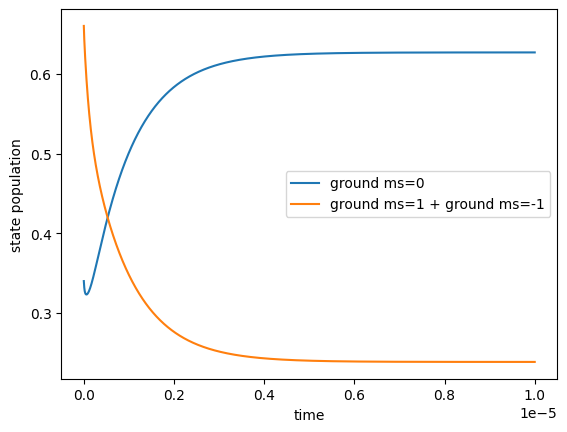

In [776]:
plt.plot(times, result.expect[3], label = 'ground ms=0')
plt.plot(times, result.expect[4], label = 'ground ms=1 + ground ms=-1')
plt.xlabel('time')
plt.ylabel('state population')
plt.legend()

Above, can see that we optically pump from ms = +-1 state to the zero state within a few microseconds. 
Although, we don't get fully polarized into ms = 0. Why not? 

In [777]:
gs_0_pop_after_optical_pump = result.expect[3][-1]
gs_p1_pop_after_optical_pump = result.expect[5][-1]
gs_m1_pop_after_optical_pump = result.expect[6][-1]

es_0_pop_after_optical_pump = result.expect[7][-1]
es_p1_pop_after_optical_pump = result.expect[8][-1]
es_m1_pop_after_optical_pump = result.expect[9][-1]

In [778]:
print(gs_0_pop_after_optical_pump)
print(gs_p1_pop_after_optical_pump)
print(gs_m1_pop_after_optical_pump)
print(es_0_pop_after_optical_pump)
print(es_p1_pop_after_optical_pump)
print(es_m1_pop_after_optical_pump)

0.6267685048801049
0.1193142864005672
0.1193142864005672
0.02710969989680676
0.0027554662783175017
0.0027554662783175017


Text(0, 0.5, 'PL rate')

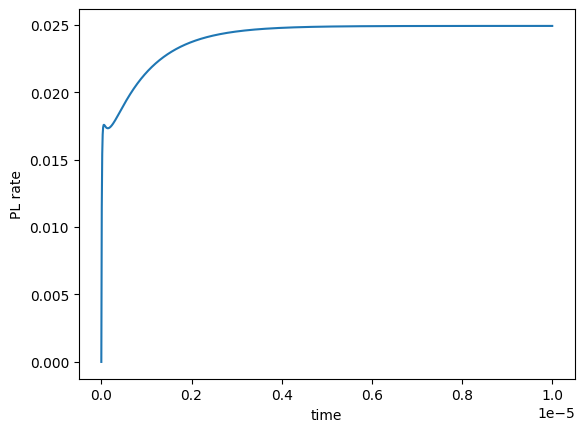

In [779]:
plt.plot(times, result.expect[0]) #this should be the PL rate....?
plt.xlabel('time')
plt.ylabel('PL rate')

In [780]:
max_PL = result.expect[0][-1]
print(max_PL)

0.024914647160547764


### What happens when the lights go out? 

In [781]:
psi0 = projection(full_h_shape, gs_m1, gs_m1) #start fully polarized into the -1 state

In [782]:
watts = 0
optical_pumping_rate = 1.1e6 * watts # optical pumping rate (example: 1/285e-9 = 3.5 MHz

gamma[gs_0,es_0] = optical_pumping_rate
gamma[gs_m1,es_m1] = optical_pumping_rate
gamma[gs_p1,es_p1] = optical_pumping_rate

In [783]:
# create dictionary of lindblad operators based on non-zero values of gamma
L = {f'{l}->{m}':np.sqrt(gamma[l,m])*projection(full_h_shape, l, m) 
         for l,m in itertools.product(range(full_h_shape), range(full_h_shape)) if gamma[l,m]!=0}

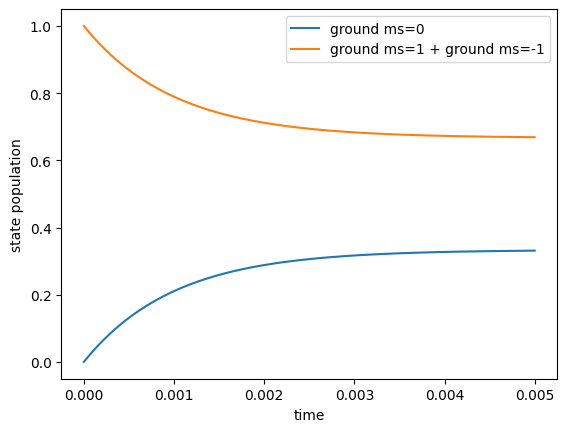

In [784]:
times = np.linspace(0,5e-3,2000)
result = qutip.mesolve(hh_full, psi0, times, L.values(), [PL_rate, P_es, P_gs, P_gs_ms_0, P_gs_mspm1])

plt.plot(times, result.expect[3], label = 'ground ms=0')
plt.plot(times, result.expect[4], label = 'ground ms=1 + ground ms=-1')
plt.xlabel('time')
plt.ylabel('state population')
plt.legend()


As hoped for, after a few milliseconds we relax into nearly equal distribution of ms = 0, 1 and -1 states.

In [785]:
# turn the lights back on
watts = 3
optical_pumping_rate = 1.1e6 * watts # optical pumping rate (example: 1/285e-9 = 3.5 MHz

gamma[gs_0,es_0] = optical_pumping_rate
gamma[gs_m1,es_m1] = optical_pumping_rate
gamma[gs_p1,es_p1] = optical_pumping_rate

# create dictionary of lindblad operators based on non-zero values of gamma
L = {f'{l}->{m}':np.sqrt(gamma[l,m])*projection(full_h_shape, l, m) 
         for l,m in itertools.product(range(full_h_shape), range(full_h_shape)) if gamma[l,m]!=0}

### Add in Rabi drive to spin +- 1 states

In [786]:
gamma[gs_0, gs_m1] = gamma[gs_m1, gs_0] = 1e6 # 1 MHz Rabi oscillation

In [789]:
# create dictionary of lindblad operators based on non-zero values of gamma
L = {f'{l}->{m}':np.sqrt(gamma[l,m])*projection(full_h_shape, l, m) 
         for l,m in itertools.product(range(full_h_shape), range(full_h_shape)) if gamma[l,m]!=0}

In [788]:
# let's start in a state that is mostly polarized into ms = 0
# we'll use the density found at the end of the first simulation

psi_opt_pump = gs_0_pop_after_optical_pump * projection(full_h_shape, gs_0, gs_0)
psi_opt_pump += gs_p1_pop_after_optical_pump * projection(full_h_shape, gs_p1, gs_p1)
psi_opt_pump += gs_m1_pop_after_optical_pump * projection(full_h_shape, gs_m1, gs_m1)
psi_opt_pump += es_0_pop_after_optical_pump * projection(full_h_shape, es_0, es_0)
psi_opt_pump += es_p1_pop_after_optical_pump * projection(full_h_shape, es_p1, es_p1)
psi_opt_pump += es_m1_pop_after_optical_pump * projection(full_h_shape, es_m1, es_m1)



In [792]:
times = np.linspace(0,10e-6,2000)
result = qutip.mesolve(hh_full, psi_opt_pump, times, L.values(), 
                       [PL_rate, P_es, P_gs, P_gs_ms_0, P_gs_mspm1, P_gs_ms_p1, P_gs_ms_m1, P_es_ms_0, P_es_ms_p1, P_es_ms_m1])

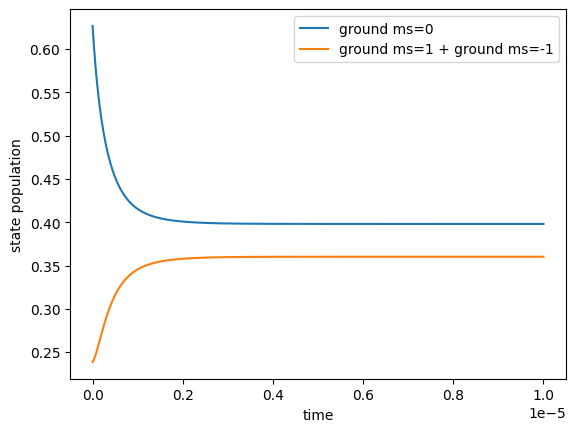

In [793]:
plt.plot(times, result.expect[3], label = 'ground ms=0')
plt.plot(times, result.expect[4], label = 'ground ms=1 + ground ms=-1')
plt.xlabel('time')
plt.ylabel('state population')
plt.legend()

In [794]:
# Rabi oscillations drive population to the +-1 states, which should be darker

Text(0, 0.5, 'PL rate')

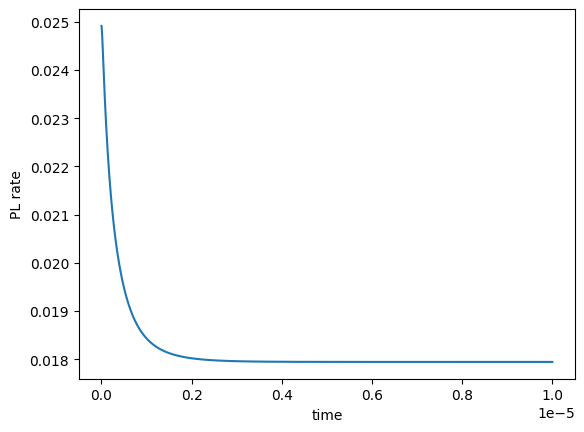

In [795]:
plt.plot(times, result.expect[0]) #this should be the PL rate....?
plt.xlabel('time')
plt.ylabel('PL rate')

In [796]:
result.expect[0][-1]

0.01794251575430458

In [797]:
contrast = result.expect[0][-1]/max_PL
print(contrast)

0.7201593359394017
